# CNN model을 활용한 가위바위보 이미지 분류기 만들기

### 라이브러리 import

In [1]:
from PIL import Image
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

### 데이터 전처리

In [2]:
def resize_images(img_path):
    images=glob.glob(img_path + "/*.jpg")  
    
    print(len(images), " images to be resized.")

    target_size=(112,112)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")

    print(len(images), " images resized.")
	
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/train/scissor"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

1100  images to be resized.
1100  images resized.
가위 이미지 resize 완료!


In [3]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/train/rock"
resize_images(image_dir_path)
print("바위 이미지 resize 완료!")

1100  images to be resized.
1100  images resized.
바위 이미지 resize 완료!


In [4]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/train/paper"
resize_images(image_dir_path)
print("보 이미지 resize 완료!")

1101  images to be resized.
1101  images resized.
보 이미지 resize 완료!


In [5]:
#데이터 준비(2) 이미지라는 입력값에 라벨링이라는 출력을 설정 하는 과정 + 정규화

import numpy as np

def load_data_new(img_path, number_of_data=3307):  # 가위바위보 이미지 개수 총합에 주의
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=112
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("전체데이터(x_data)의 이미지 개수는", idx,"입니다.")
    return imgs, labels


image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/train"
(x_data, y_data)=load_data_new(image_dir_path)

print("x_data shape: {}".format(x_data.shape))
print("y_data shape: {}".format(y_data.shape))


전체데이터(x_data)의 이미지 개수는 3301 입니다.
x_data shape: (3307, 112, 112, 3)
y_data shape: (3307,)


 #### 전체 데이터를 training, validation, test set 으로 나누기

In [6]:
def train_val_test_split(ds, ds_size, sd, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # trainning set, validation set, test set 을 동일하게 섞기 위해 seed 를 설정
        ds_shuffled = np.random.RandomState(seed=sd).permutation(ds)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds_shuffled[0:train_size]    
    val_ds = ds_shuffled[train_size:train_size+val_size]
    test_ds = ds_shuffled[train_size+val_size:]
    
    return train_ds, val_ds, test_ds

In [7]:
x_train_new, x_val_new, x_test_new = train_val_test_split(x_data,3307,15)
y_train_new, y_val_new, y_test_new = train_val_test_split(y_data,3307,15)

In [8]:
print(x_train_new.shape)
print(x_val_new.shape)
print(x_test_new.shape)

(2645, 112, 112, 3)
(330, 112, 112, 3)
(332, 112, 112, 3)


In [9]:
print(y_train_new.shape)
print(y_val_new.shape)
print(y_test_new.shape)

(2645,)
(330,)
(332,)


라벨:  2


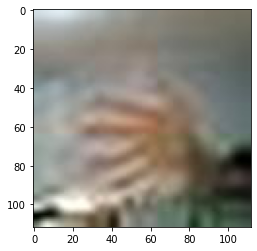

In [10]:
plt.imshow(x_val_new[0])
print('라벨: ', y_val_new[0])

라벨:  1


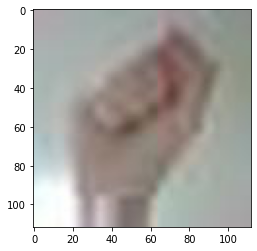

In [11]:
plt.imshow(x_test_new[0])
print('라벨: ', y_test_new[0])

## 딥러닝 네트워크 설계

In [13]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(112,112,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))


model.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 110, 110, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 21632)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                692256    
_________________________________________________________________
dense_1 (Dense)              (No

## 딥러닝 네트워크 학습시키기

In [15]:
# 최선의 답을 찾아 가는 과정 LMS 1-4 딥러닝 네트워크 학습 
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy', #오류제거
             metrics=['accuracy']) #평가지표

model.fit(x_train_new, y_train_new, epochs=10) #학습을 시키는 부분

Epoch 1/10
83/83 [==============================] - 4s 8ms/step - loss: 11.6934 - accuracy: 0.6174
Epoch 2/10
83/83 [==============================] - 1s 7ms/step - loss: 0.3094 - accuracy: 0.8775
Epoch 3/10
83/83 [==============================] - 1s 7ms/step - loss: 0.2548 - accuracy: 0.9078
Epoch 4/10
83/83 [==============================] - 1s 6ms/step - loss: 0.1661 - accuracy: 0.9376
Epoch 5/10
83/83 [==============================] - 1s 7ms/step - loss: 0.1238 - accuracy: 0.9546
Epoch 6/10
83/83 [==============================] - 1s 7ms/step - loss: 0.0684 - accuracy: 0.9743
Epoch 7/10
83/83 [==============================] - 1s 7ms/step - loss: 0.0458 - accuracy: 0.9849
Epoch 8/10
83/83 [==============================] - 1s 7ms/step - loss: 0.0300 - accuracy: 0.9928
Epoch 9/10
83/83 [==============================] - 1s 7ms/step - loss: 0.0633 - accuracy: 0.9826
Epoch 10/10
83/83 [==============================] - 1s 7ms/step - loss: 0.0668 - accuracy: 0.9781


## 모델 성능 평가

다른 사람의 가위, 바위, 보 이미지를 이용하여 모델의 성능을 평가해 본다.

학습용 이미지와 같이 시험용 이미지도 size 28x28 로 resize 한다

In [16]:
test_loss, test_accuracy = model.evaluate(x_val_new, y_val_new, verbose = 2)

print("test_loss : {}".format(test_loss))
print("test_accuracy : {}".format(test_accuracy))

11/11 - 0s - loss: 0.1409 - accuracy: 0.9606
test_loss : 0.14086806774139404
test_accuracy : 0.960606038570404


In [17]:
test_loss, test_accuracy = model.evaluate(x_test_new, y_test_new, verbose = 2)

print("최종 test_loss : {}".format(test_loss))
print("최종 test_accuracy : {}".format(test_accuracy))

11/11 - 0s - loss: 0.0652 - accuracy: 0.9789
최종 test_loss : 0.06519363820552826
최종 test_accuracy : 0.9789156913757324


예측확률분포: [0.5569275  0.00820331 0.43486917]
라벨: 2, 예측결과: 0


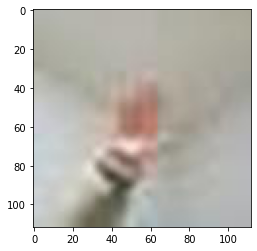

예측확률분포: [0.4622222  0.09761199 0.44016573]
라벨: 2, 예측결과: 0


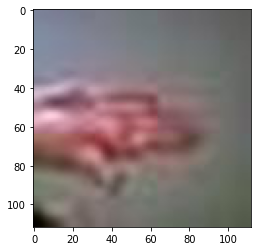

예측확률분포: [0.5569275  0.00820331 0.43486917]
라벨: 2, 예측결과: 0


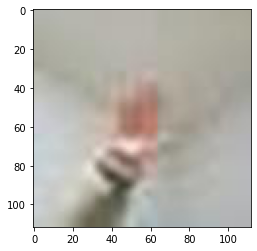

예측확률분포: [4.9259357e-11 7.9851532e-01 2.0148467e-01]
라벨: 2, 예측결과: 1


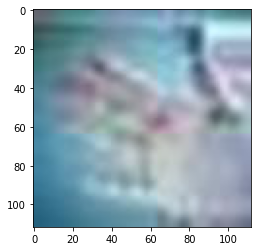

예측확률분포: [0.01426451 0.18859814 0.7971374 ]
라벨: 1, 예측결과: 2


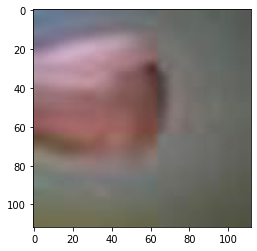

In [18]:
predicted_result = model.predict(x_test_new)  
predicted_labels = np.argmax(predicted_result, axis=1)

import random
wrong_predict_list=[]
for i, _ in enumerate(predicted_labels):
    # i번째 test_labels과 y_test이 다른 경우만 모음
    if predicted_labels[i] != y_test_new[i]:
        wrong_predict_list.append(i)

# wrong_predict_list 에서 랜덤하게 5개만 뽑기
samples = random.choices(population=wrong_predict_list, k=5)

for n in samples:
    print("예측확률분포: " + str(predicted_result[n]))
    print("라벨: " + str(y_test_new[n]) + ", 예측결과: " + str(predicted_labels[n]))
    plt.imshow(x_test_new[n], cmap=plt.cm.binary)
    plt.show()

### Report

1. 가위를 0, 바위를 1, 보를 2로 라벨링하여 각 이미지들을 분류하게 하였음.
2. 첫번째 시도때에는 Validation set를 적용하지 않았는데 라벨을 제대로 인식하지 못하는 문제점이 발생하였음.(과대 적합을 방지할 수 있는 검증 세트가 필요 했음)
3. 데이터 훈련셋트를 300개에서 3300개 가량으로 대폭 올렸으며, 훈련이 잘 될 수 있도록 선명한 이미지를 훈련 시킬 수 있도록 함.
4. 데이터를 불러올 때, shuffle기능을 사용하여 데이터들을 적절하게 섞고 train set를 80% 나머지 훈련 및 검증 셋은 각 각 10%씩 배분함.
5. 모델 훈련 시 epoch를 10으로 설정했는데 8번 때에는 accuracy가 99퍼 센트 였지만, 그 이후로는 오히려 떨어지면서 overfitting 된다고 판단함.
6. 모델의 라벨을 재확인 하였을 때 이상이 없는 것으로 판단되어 수정하지 않았음.